Stats for band 1: {'min': 0.0, 'max': 255.0, 'mean': 84.26829801493692, 'std': 86.92899820584962}


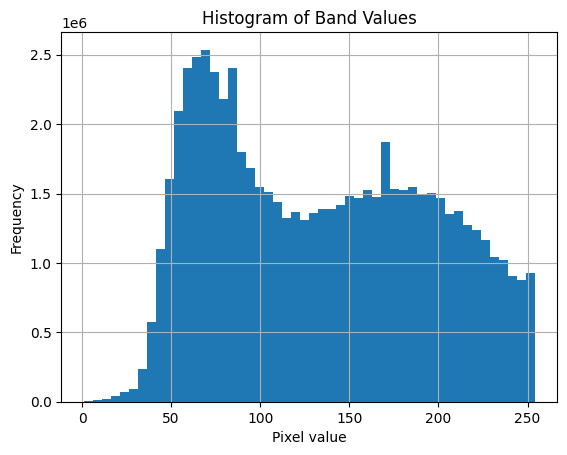

In [0]:
# -----------------------------------------------------------------------------
# Notebook: Single-Item Raster Inspection (Sentinel-2 Visual Asset)
# -----------------------------------------------------------------------------
# Purpose:
#   Demonstrate how to:
#     1. Authenticate to Microsoft Planetary Computer Pro (GeoCatalog) using a
#        User Assigned Managed Identity on a Databricks cluster.
#     2. Request a short‑lived SAS token for a protected collection.
#     3. Locate a specific STAC Item (already ingested into a Delta table by the
#        ingestion notebook) and extract the 'visual' asset HREF.
#     4. Open the Cloud Optimized GeoTIFF with rasterio directly from object
#        storage using the SAS token query string.
#     5. Compute quick descriptive statistics and visualize the pixel value
#        distribution with a histogram for rapid QA / exploratory analysis.
#
# When To Use:
#   - Verifying identity-based access is working.
#   - Spot‑checking a scene before scaling to distributed processing.
#   - Building intuition about pixel value ranges & potential normalization.
#
# Prerequisites:
#   - Delta table `rt_demo.default.sentinel2` created by the STAC ingestion notebook.
#   - Libraries: azure-identity, requests, rasterio, numpy, matplotlib.
#
# Customization Tips:
#   - Change `item_id` to inspect a different scene (or implement a query by
#     date/cloud cover first).  Example: filter Delta table: `.where("properties.eo:cloud_cover < 10")`.
#   - Swap the asset key (`visual`) for another (e.g., 'B04', 'B08') if present.
#   - Extend statistics dictionary with percentiles or masked statistics.
# -----------------------------------------------------------------------------

from azure.identity import ManagedIdentityCredential
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import requests

# Audience / resource scope for GeoCatalog when requesting AAD token.
MPCPRO_APP_ID = "https://geocatalog.spatio.azure.com"

# -----------------------------------------------------------------------------
# 1. Authenticate using Managed Identity (no secrets / keys needed)
# -----------------------------------------------------------------------------
credential = ManagedIdentityCredential()
# Acquire a bearer token scoped to GeoCatalog; token contains expiry metadata.
token = credential.get_token(MPCPRO_APP_ID)

# Base service endpoint (region-specific) & collection identifier.
# Replace with your own Geocatalog url
geocatalog_url = "{REPLACE-WITH-YOUR-GEOCATALOG-ENDPOINT}"
collection_id = "sentinel-2-l2a"

# -----------------------------------------------------------------------------
# 2. Request a SAS token granting time‑bound read access to collection assets
#    This indirection keeps raw storage credentials abstracted behind the service.
# -----------------------------------------------------------------------------
headers = {
    "Authorization": f"Bearer {token.token}",
}
params = {
    "api-version": "2025-04-30-preview",  
}
response = requests.get(
    f"{geocatalog_url}/sas/token/{collection_id}",
    headers=headers,
    params=params,
)
response.raise_for_status()
sas_token = response.json()["token"]  # Do not log token in production notebooks.

# -----------------------------------------------------------------------------
# 3. Retrieve a specific STAC Item's visual asset HREF from the Delta table
#    The ingestion notebook materialized STAC metadata including assets map.
# -----------------------------------------------------------------------------
item_id = "S2A_MSIL2A_20230816T105631_R094_T30SUJ_20230816T171602"  # Replace for other scenes

# Select the 'visual' asset's href (COG URL base). The resulting string excludes the SAS query part.
visual_href = (
    spark.table("rt_demo.default.sentinel2")
         .where(f"id = '{item_id}'")
         .select("assets.visual.href")
         .collect()[0]["href"]
)

# -----------------------------------------------------------------------------
# 4. Open the raster with rasterio
#    The SAS token is appended as a query string to authorize blob access.
#    We read only band 1 of the visual composite (usually a rendered RGB product
#    may expose 3 bands; for demonstration we sample index 1). Adapt as needed.
# -----------------------------------------------------------------------------
with rasterio.open(f"{visual_href}?{sas_token}") as src:
    band = src.read(1)  # Reads the first band into a NumPy array
    stats = {
        "min": float(np.min(band)),
        "max": float(np.max(band)),
        "mean": float(np.mean(band)),
        "std": float(np.std(band)),
    }

print(f"Stats for band 1: {stats}")

# -----------------------------------------------------------------------------
# 5. Visualize distribution
#    We filter out zero / saturated values to emphasize the meaningful range.
#    Adjust thresholds per product (e.g., reflectance scaling) as appropriate.
# -----------------------------------------------------------------------------
filtered_band = band[(band > 0) & (band < 255)]
plt.figure(figsize=(7,4))
plt.hist(filtered_band.flatten(), bins=50, color="#3366cc", edgecolor="white")
plt.title("Histogram of Band 1 Pixel Values (Filtered)")
plt.xlabel("Pixel value")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Optional next steps (uncomment / adapt):
# - Compute percentiles: np.percentile(filtered_band, [5, 50, 95])
# - Stretch visualization using min/max or percentile clipping
# - Save stats to a Delta table for longitudinal analysis
print("Raster inspection complete.")